### Optimal control of the Wilson Cowan model with different sparsity cost
This notebook shows how to compute the optimal control (OC) signal for the Wilson Cowan model for a state-switching task, when different cost functionals are applied.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [16]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 200.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
input = np.ones((zero_input.shape)) * 4.
control = zero_control.copy()
control[0,0,:] = 4.
control[0,1,:] = 4.
control[0,0,:200] += 15.
control[0,0,1000:1200] -= 15.

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
model.params["exc_ext"] = control[:,0,:]
model.params["inh_ext"] = control[:,1,:]

model.run()
up = [model.exc[0,999], model.inh[0,999]]
down = [model.exc[0,-1], model.inh[0,-1]]

duration = 50.
model.params["duration"] = duration
model.run()
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
input = np.ones((zero_input.shape)) * 4.

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

target = np.ones((state.shape))
target[0,0,:] = up[0]
target[0,1,:] = up[1]

x_init = down[0]
y_init = down[1]
model.params["exc_init"] = np.array([[x_init]])
model.params["inh_init"] = np.array([[y_init]])



Compute control for a deterministic system
Cost in iteration 0: 2.606698145218197
Cost in iteration 1: 2.603106177971362
Cost in iteration 2: 2.5930932719215534
Cost in iteration 3: 2.593021825453193
Cost in iteration 4: 2.5151620704888784
Cost in iteration 5: 0.6711518443399098
Cost in iteration 6: 0.6147474513078255
Cost in iteration 7: 0.5018053362398791
Cost in iteration 8: 0.2923745765044299
Cost in iteration 9: 0.24070280865905558
Cost in iteration 10: 0.2338850014540766
Final cost : 0.2338850014540766
Compute control for a deterministic system
Cost in iteration 0: 0.2338850014540766
Cost in iteration 1: 0.22969325366463675
Cost in iteration 2: 0.2244757099734092
Cost in iteration 3: 0.22423256535467256
Cost in iteration 4: 0.22320952873934108
Cost in iteration 5: 0.21372616411036358
Cost in iteration 6: 0.2059493980438892
Cost in iteration 7: 0.2048936994269083
Cost in iteration 8: 0.20228006529981074
Cost in iteration 9: 0.19943822724612015
Cost in iteration 10: 0.1985038279594

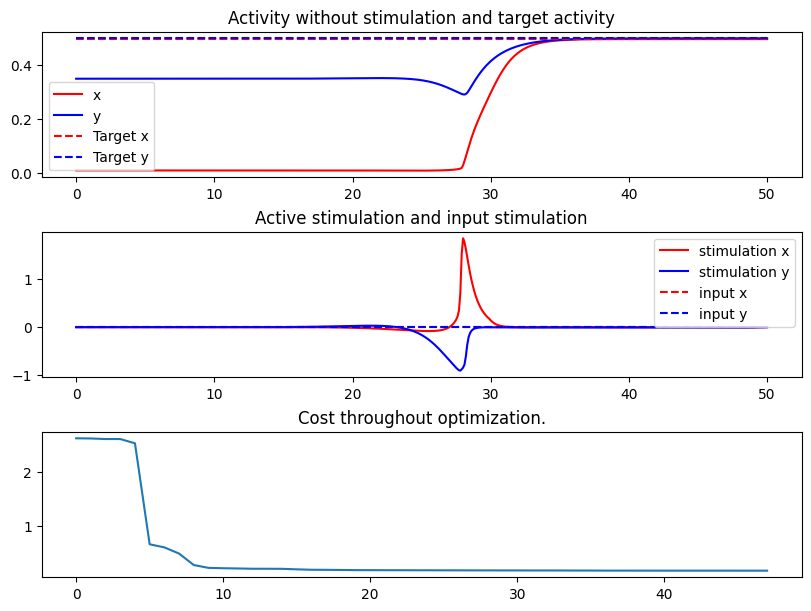

In [36]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["exc_ext"] = input
model.params["inh_ext"] = input

model_controlled = oc_wc.OcWc(model, target, w_p=1e0, w_2=1e-1, print_array=np.arange(0,101,1), precision_cost_interval=(300, None))

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.step = 1e4
model_controlled.optimize(10)

model_controlled.step = 1e3
model_controlled.optimize(1000)


state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, zero_control, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 26.066981452181974
Final cost : 1.7430687177281294
Compute control for a deterministic system
Cost in iteration 0: 1.7430687177281294
Cost in iteration 50: 0.9792846210604113
Cost in iteration 100: 0.963581188053967
Cost in iteration 150: 0.9501709864721652
Cost in iteration 200: 0.9406472485606006
Cost in iteration 250: 0.9372631890898826
Cost in iteration 300: 0.9358298469630946
Cost in iteration 350: 0.9343908380206776
Cost in iteration 400: 0.9329636668911353
Cost in iteration 450: 0.9315369132235226
Cost in iteration 500: 0.9301103001385328
Cost in iteration 550: 0.9286840908593929
Cost in iteration 600: 0.927255110759479
Cost in iteration 650: 0.9258323830204579
Cost in iteration 700: 0.924413642245971
Cost in iteration 750: 0.9230040677821136
Cost in iteration 800: 0.9216217853914255
Cost in iteration 850: 0.9202562634349486
Cost in iteration 900: 0.9188881159000957
Cost in iteration 950: 0.9176169018656885
Cost in 

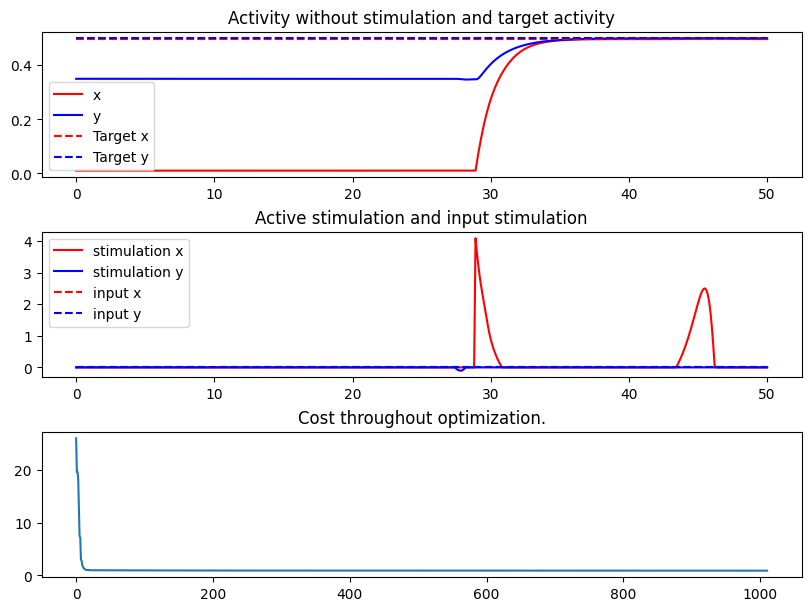

In [40]:
# Repeat computation with sparsity cost
model.params["exc_ext"] = input
model.params["inh_ext"] = input

model_controlled = oc_wc.OcWc(model, target, w_p=1e1, w_2=0, w_1=1e-1, print_array=np.arange(0,1001,50), precision_cost_interval=(300, None))

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.step = 1e3
model_controlled.optimize(10)

model_controlled.step = 1e2
model_controlled.optimize(1000)


state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, zero_control, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 26.066981452181974
Final cost : 0.7754349598012825
Compute control for a deterministic system
Cost in iteration 0: 0.7754349598012825
Converged in iteration 19 with cost 0.7707275254504712
Final cost : 0.7707275254504712


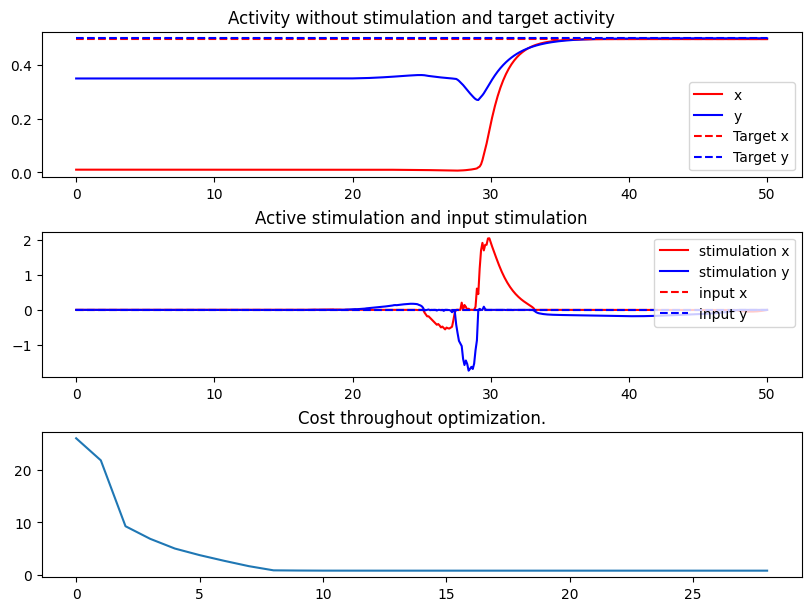

In [43]:
# Repeat computation with temporal sparsity cost
model.params["exc_ext"] = input
model.params["inh_ext"] = input

model_controlled = oc_wc.OcWc(model, target, w_p=1e1, w_2=0, w_1T=1e-1, print_array=np.arange(0,1001,50), precision_cost_interval=(300, None))

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.step = 1e1
model_controlled.optimize(10)

model_controlled.step = 1e0
model_controlled.optimize(1000)


state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, zero_control, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 26.066981452181974
Final cost : 8.263181484728081
Compute control for a deterministic system
Cost in iteration 0: 8.263181484728081
Cost in iteration 50: 0.41655561868993063
Cost in iteration 100: 0.3954476980828648
Cost in iteration 150: 0.3954438655905376
Cost in iteration 200: 0.3954399250110644
Cost in iteration 250: 0.39543612389502164
Cost in iteration 300: 0.3954321878531744
Cost in iteration 350: 0.3954283661664241
Cost in iteration 400: 0.3954244846644144
Cost in iteration 450: 0.39542059685280795
Cost in iteration 500: 0.395416771904511
Cost in iteration 550: 0.39541283333509636
Cost in iteration 600: 0.3954090363688103
Converged in iteration 614 with cost 0.3954080748788834
Final cost : 0.3954080748788834


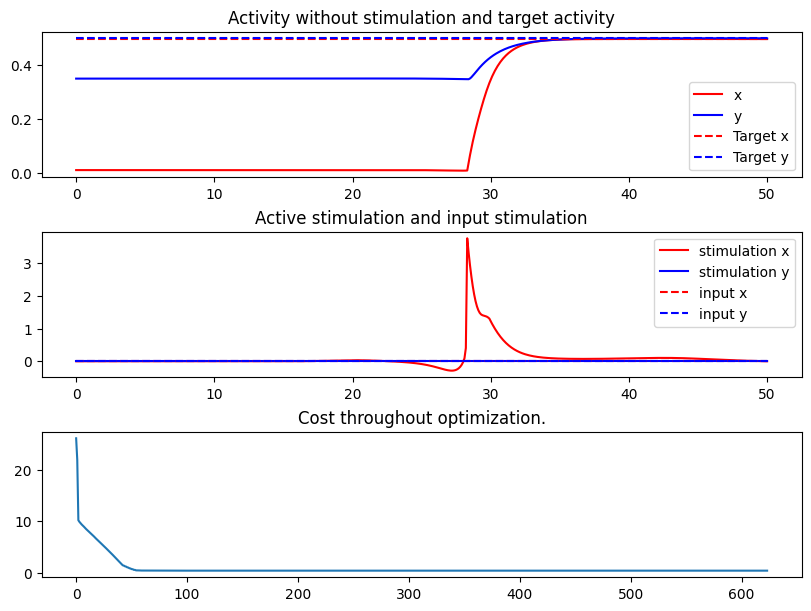

In [45]:
# Repeat computation with directional sparsity cost
model.params["exc_ext"] = input
model.params["inh_ext"] = input

model_controlled = oc_wc.OcWc(model, target, w_p=1e1, w_2=0, w_1D=1e-1, print_array=np.arange(0,1001,50), precision_cost_interval=(300, None))

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.step = 1e1
model_controlled.optimize(10)

model_controlled.step = 1e1
model_controlled.optimize(1000)


state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, zero_control, model_controlled.cost_history)